### Q1
2.Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html


In [4]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm

In [5]:
n = 100
p=3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))


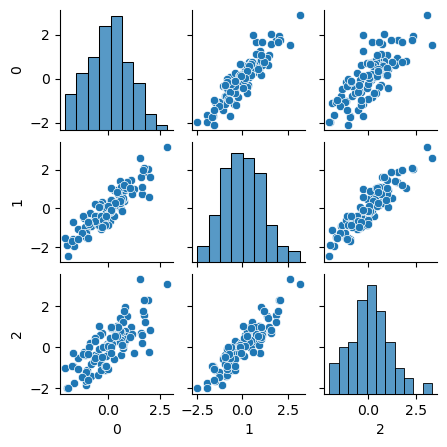

In [6]:
import seaborn
import pandas as pd
seaborn.pairplot(pd.DataFrame(x),height=1.5);

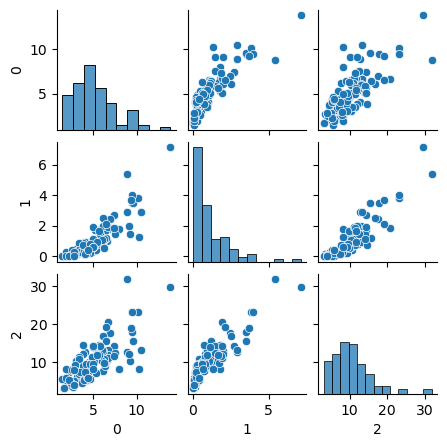

In [7]:
seaborn.pairplot(pd.DataFrame(y),height=1.5);

The two steps in the documentation to fit a copula is:
1. Estimate the parameters of the marginal distributions.

2. Estimate the covariance parameter of the copula, using point estimates of the marginal distribution parameters from step 1.

In [6]:
# First: Marginal Estimation with PyMC 
marginal_params = {}

# Gamma for y[:,0]
with pm.Model() as gamma_model:
    alpha = pm.HalfNormal("alpha", sigma=10)
    beta = pm.HalfNormal("beta", sigma=10)
    pm.Gamma("y_obs", alpha=alpha, beta=beta, observed=y[:, 0])
    trace_gamma = pm.sample(1000, tune=1000, target_accept=0.9)
    marginal_params["gamma"] = az.summary(trace_gamma, var_names=["alpha", "beta"]).mean()["mean"]

# Exponential for y[:,1]
with pm.Model() as exp_model:
    lam = pm.HalfNormal("lam", sigma=10)
    pm.Exponential("y_obs", lam, observed=y[:, 1])
    trace_exp = pm.sample(1000, tune=1000, target_accept=0.9)
    marginal_params["exp"] = az.summary(trace_exp, var_names=["lam"]).mean()["mean"]

# Chi-squared for y[:,2]
with pm.Model() as chi2_model:
    nu = pm.HalfNormal("nu", sigma=10)
    pm.ChiSquared("y_obs", nu=nu, observed=y[:, 2])
    trace_chi2 = pm.sample(1000, tune=1000, target_accept=0.9)
    marginal_params["chi2"] = az.summary(trace_chi2, var_names=["nu"]).mean()["mean"]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [7]:
#Second: Copula Model in PyMC
#Transform y into standard normal space, then fit a multivariate normal with unknown correlation:

# Use posterior means from above
from scipy.stats import norm, gamma, expon, chi2
gamma_summary = az.summary(trace_gamma, var_names=["alpha", "beta"])
a = gamma_summary.loc["alpha", "mean"]
b = gamma_summary.loc["beta", "mean"]
marginal_params["gamma"] = (a, b)

exp_summary = az.summary(trace_exp, var_names=["lam"])
lam = exp_summary.loc["lam", "mean"]
marginal_params["exp"] = lam

chi2_summary = az.summary(trace_chi2, var_names=["nu"])
nu = chi2_summary.loc["nu", "mean"]
marginal_params["chi2"] = nu






#a, b = marginal_params["gamma"]
#lam = marginal_params["exp"]
#nu = marginal_params["chi2"]

# Transform to copula scale
z0 = norm.ppf(gamma.cdf(y[:, 0], a=a, scale=1/b))
z1 = norm.ppf(expon.cdf(y[:, 1], scale=1/lam))
z2 = norm.ppf(chi2.cdf(y[:, 2], df=nu))

Z_obs = np.column_stack([z0, z1, z2])

# Fit copula model
with pm.Model() as copula_model:
    L, R, stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                   sd_dist=pm.Exponential.dist(1.0, shape=3),
                                   compute_corr=True)
    pm.MvNormal("z", mu=np.zeros(3), chol=L, observed=Z_obs)
    copula_trace = pm.sample(1000, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.


In [39]:
print(copula_trace.posterior)

<xarray.Dataset> Size: 584kB
Dimensions:       (chain: 4, draw: 1000, R_dim_0: 6, R_corr_dim_0: 3,
                   R_corr_dim_1: 3, R_stds_dim_0: 3)
Coordinates:
  * chain         (chain) int64 32B 0 1 2 3
  * draw          (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * R_dim_0       (R_dim_0) int64 48B 0 1 2 3 4 5
  * R_corr_dim_0  (R_corr_dim_0) int64 24B 0 1 2
  * R_corr_dim_1  (R_corr_dim_1) int64 24B 0 1 2
  * R_stds_dim_0  (R_stds_dim_0) int64 24B 0 1 2
Data variables:
    R             (chain, draw, R_dim_0) float64 192kB 0.9959 0.9142 ... 0.4577
    R_corr        (chain, draw, R_corr_dim_0, R_corr_dim_1) float64 288kB 1.0...
    R_stds        (chain, draw, R_stds_dim_0) float64 96kB 0.9959 ... 1.094
Attributes:
    created_at:                 2025-03-26T03:07:42.817126+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.10.4
    sampling_time:              109.91070556640625
    tuning_steps:

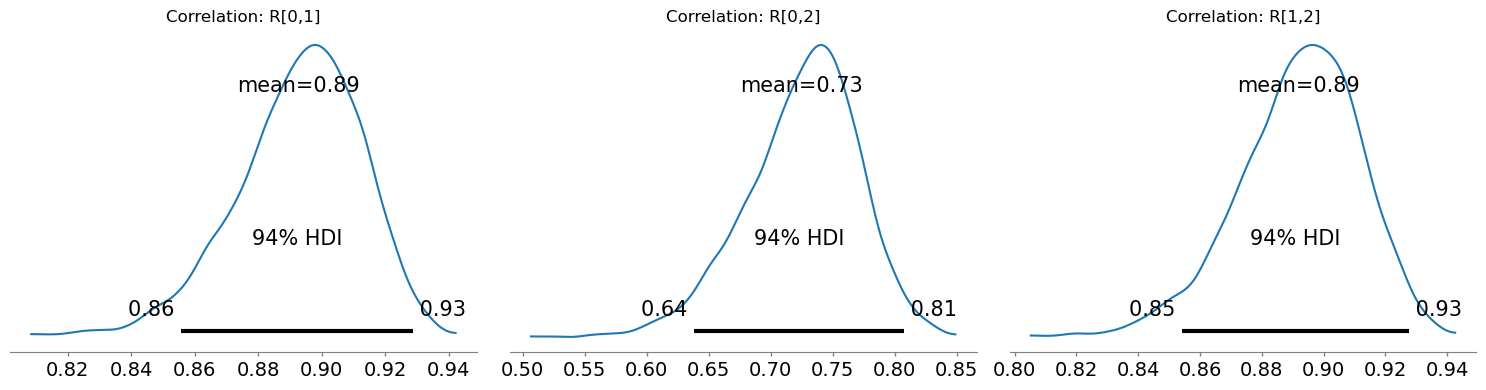

In [40]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Stack chain and draw dimensions into a single axis
R_corr = copula_trace.posterior["R_corr"].stack(sample=("chain", "draw"))

# Extract individual correlations
r01 = R_corr.sel(R_corr_dim_0=0, R_corr_dim_1=1).values
r02 = R_corr.sel(R_corr_dim_0=0, R_corr_dim_1=2).values
r12 = R_corr.sel(R_corr_dim_0=1, R_corr_dim_1=2).values

# Plot them
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

az.plot_posterior(r01, ax=axes[0], hdi_prob=0.94)
axes[0].set_title("Correlation: R[0,1]")

az.plot_posterior(r02, ax=axes[1], hdi_prob=0.94)
axes[1].set_title("Correlation: R[0,2]")

az.plot_posterior(r12, ax=axes[2], hdi_prob=0.94)
axes[2].set_title("Correlation: R[1,2]")

plt.tight_layout()
plt.show()

array([[<Axes: title={'center': 'R'}>, <Axes: title={'center': 'R'}>]],
      dtype=object)

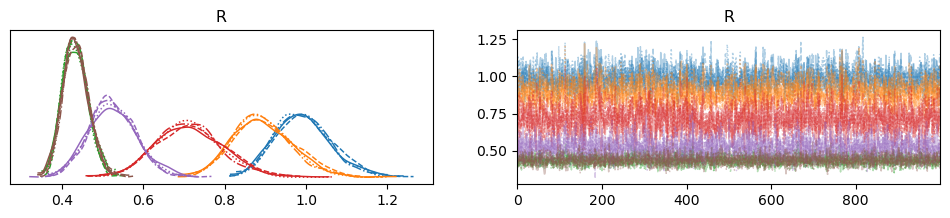

In [10]:
az.plot_trace(copula_trace,var_names=['R'])

##### 3. Describe what a copula is and how the two versions of code implement it

A copula is a statistical tool used to describe the dependence structure between random variables, independently of their marginal distributions. In simpler terms, a copula lets you model how variables are related (i.e., their joint behavior), even when each variable follows a different distribution. Copulas are particularly powerful in situations where the marginals are not all normally distributed, which is common in real-world data.

In the prof's version all parameters, including those of the marginal distributions and the copula correlation structure, are estimated jointly within a single PyMC model. This approach allows for full uncertainty propagation, meaning the variability in estimating marginal parameters is properly accounted for when modeling the dependence structure. However, this model can be computationally inefficent and complex to implement, particularly due to shape and broadcasting issues when working with transformed distributions.

By contrast, the two-pass method suggested in the PyMC documentation takes a more practical approach. It first estimates the covariance parameters of the marginals separately (typically using point estimates such as posterior means), then transforms the data into a common copula space (e.g. standard normal) using those estimates, and finally fits a multivariate normal model to the transformed data to capture the dependencies. While this approach is computationally more efficient and easier to code, it sacrifices some theoretical rigor because it does not account for uncertainty in the marginal parameters during copula estimation.

Therefore, the prof's approach is theoretically better as it adheres more closely to Bayesian principles by propagating uncertainty through all model components. However, the two-pass approach offers a valuable trade-off for situations where computational efficiency is necessary and the loss of precision is acceptable.

##### 4.Describe how to use this to create arbitrary multivariate GLM regressions

To create arbitrary multivariate GLM regressions using a copula approach, we first model each outcome variable separately using an appropriate GLM (e.g., Gamma, Poisson), allowing different covariates and distributions. After estimating the marginal distributions, we transform the outcomes to the standard normal space using their fitted CDFs followed by the inverse normal CDF. Then, we model the joint dependence using a multivariate normal distribution with a copula, typically with an LKJ prior on the correlation matrix. 

### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



For the computation efficiency purposes I would use synthesis data here. 

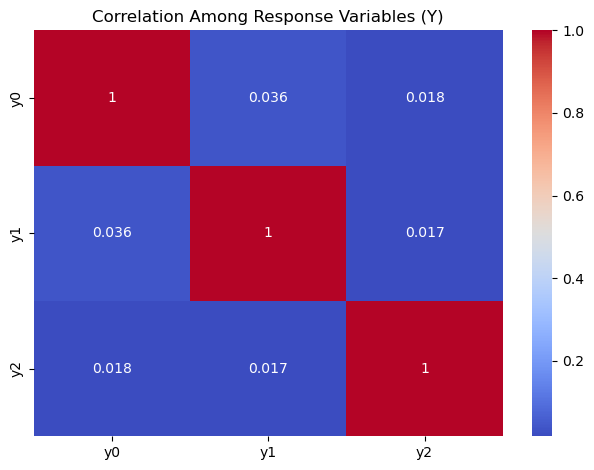

,x0,x1,x2,x3,x4,x5,x6,x7
0,1.021154,-2.543988,-1.702368,-0.286313,-0.908156,0.103355,0.178935,1.249103
1,-0.222012,0.682181,0.258046,-0.178087,-2.589496,0.758899,-2.658294,-0.153241
2,0.462763,0.536247,-0.892230,0.068364,-1.585839,-0.303551,0.052146,0.439093
3,-1.039101,-0.573985,-0.227692,-0.430670,0.446340,0.635795,0.049923,-2.117124
4,1.999361,0.981955,0.134402,0.135589,1.830264,-0.075299,-0.918939,0.497166
...,...,...,...,...,...,...,...,...
95,0.880927,-1.335070,-2.574909,0.555503,0.657294,-1.630514,0.301538,-0.676005
96,0.101940,-0.545223,0.910093,-2.096966,1.909158,0.772215,-1.036655,0.985501
97,0.919275,-0.690158,-0.013330,-2.152605,1.967958,1.132831,-0.784101,-1.302650
98,0.152827,0.463311,-0.883374,0.135820,1.921779,1.554061,0.509337,-0.908177


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set seed for reproducibility
np.random.seed(1007691348)

# Parameters
n = 100  # observations
p = 8   # predictors
m = 3    # response variables

# Generate design matrix X
X = np.random.normal(0, 1, size=(n, p))

# Define sparse coefficient matrix B_true
B_true = np.zeros((p, m))
B_true[[1, 3], 0] = [2.0, -1.5]       # y0
B_true[[0, 4], 1] = [-1.0, 1.5]       # y1
B_true[[2, 5], 2] = [1.0, -1.0]       # y2

# Generate Y = XB + noise
Y = X @ B_true + np.random.normal(0, 1, size=(n, m))

# Wrap in DataFrames
X_df = pd.DataFrame(X, columns=[f"x{i}" for i in range(p)])
Y_df = pd.DataFrame(Y, columns=[f"y{i}" for i in range(m)])

# Plot correlation matrix of response variables
sns.heatmap(Y_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Among Response Variables (Y)")
plt.tight_layout()
plt.show()



X_df


In [14]:
Y_df

,y0,y1,y2
0,-4.899900,-1.999431,-1.864176
1,2.883500,-2.854722,-1.012783
2,-0.654466,-3.567859,-1.001748
3,1.386174,2.510065,0.183561
4,3.528082,0.505105,-2.293565
...,...,...,...
95,-1.234877,-0.349716,-1.220453
96,4.004309,2.167795,-0.563334
97,1.064440,2.662658,-1.673838
98,0.626211,1.854716,-4.066769


In [17]:
!pip install aesara

In [18]:
#spike_and_slab variable selection priors

# Assume X is my (n x p) predictor matrix, and y is my (n,) response vector
#n, p = X.shape

import pymc as pm
import numpy as np
import aesara.tensor as at


n, p = X.shape   # X: (100, 8)
_, m = Y.shape   # Y: (100, 3)

with pm.Model() as spike_slab_model:

    # Inclusion indicators for each coefficient (p × m matrix)
    spike = pm.Bernoulli('spike', p=0.5, shape=(p, m))

    # Slab: diffuse Normal priors for coefficients when included
    slab = pm.Normal('slab', mu=0, sigma=10, shape=(p, m))

    # Final regression coefficients (element-wise mask)
    beta = pm.Deterministic('beta', spike * slab )

    # Noise standard deviation for each response variable
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)

    # Linear predictor (n × m): X (n × p) × b (p × m) = mu (n × m)
    mu = pm.math.dot(X, beta)

    # Likelihood: independent normal errors across responses
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

    # Sample from posterior
    idata_spike = pm.sample(1000, tune=1000, cores=1, random_seed=123)


Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [spike]
>NUTS: [slab, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


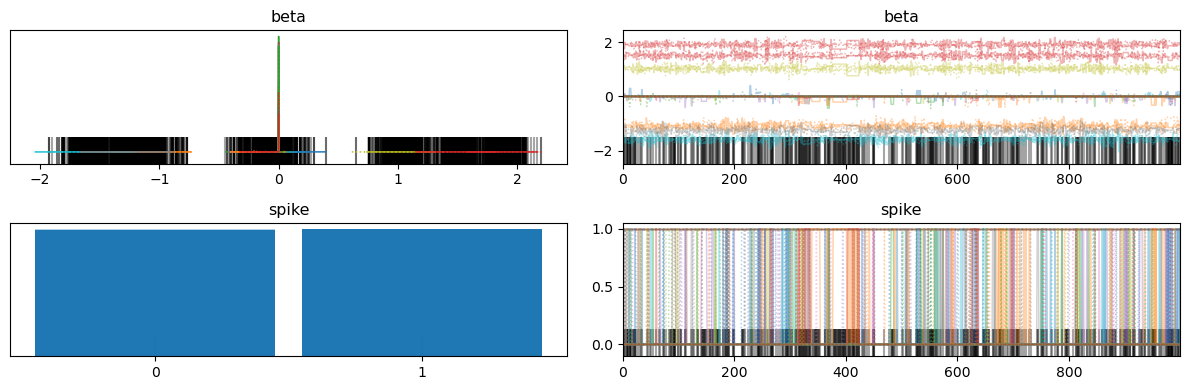

In [19]:
az.plot_trace(idata_spike, var_names=['beta', 'spike'])
plt.tight_layout()
plt.show()

In [90]:
#Diffuse Normal Priors 

import pymc as pm

with pm.Model() as diffuse_model:
    
    # Prior on coefficients: weakly informative Normal(0, 10)
    b = pm.Normal("b", mu=0, sigma=10, shape=(p, m))  # shape: (predictors, responses)
    
    # Prior on noise standard deviation for each response
    sigma = pm.HalfNormal("sigma", sigma=1, shape=m)  # shape: (responses,)
    
    # Linear predictor: shape (n, m)
    mu = pm.math.dot(X, b)
    
    # Likelihood: Y observed as Normal with mu and sigma
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    
    # Sampling
    idata_diffuse = pm.sample(1000, tune=1000, random_seed=123, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


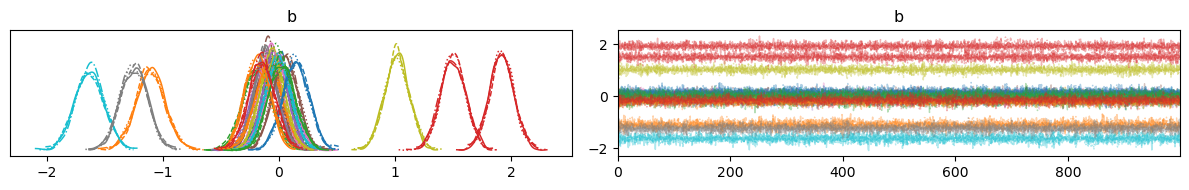

In [91]:
az.plot_trace(idata_diffuse, var_names=['b'])
plt.tight_layout()
plt.show()

<Axes: title={'center': 'beta'}>

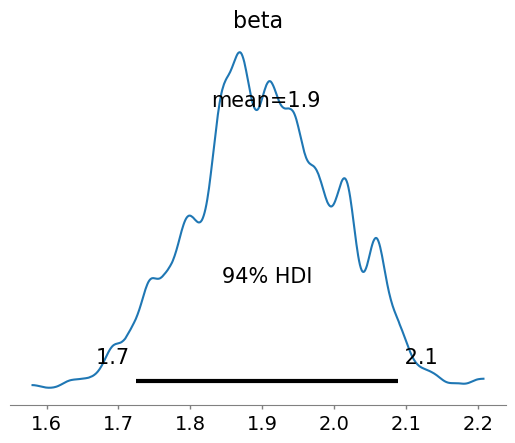

In [22]:
az.plot_posterior(idata_spike, var_names=["beta"], coords={"beta_dim_0": 1, "beta_dim_1": 0})


The comparison between the Spike-and-Slab model and the Diffuse Normal Priors model reveals clear differences in variable selection and coefficient estimation. The Spike-and-Slab model introduces binary inclusion variables (gamma) that effectively distinguish between relevant and irrelevant predictors, shrinking many coefficients exactly to zero. This results in a sparse, interpretable model where only a few predictors significantly influence the response. In contrast, the Diffuse Normal Priors model applies minimal regularization, allowing all coefficients to vary freely. As a result, even noise variables exhibit non-zero estimates, which can lead to overfitting and reduced interpretability. The trace plots support these observations, showing tighter and sparser distributions in the Spike-and-Slab model compared to the more diffuse patterns in the normal prior model.

As the number of observations n increases, the computational cost grows approximately linearly, since the model must evaluate the likelihood for each data point. However, this increase is generally manageable, as larger datasets can also lead to more concentrated posteriors, potentially reducing the number of effective samples needed.  In contrast, the number of predictors p plays a more significant role in computational complexity. Each predictor contributes to the total number of regression coefficients across all response variables, and in models using the horseshoe prior, each coefficient is accompanied by local and global shrinkage parameters.  As a result, increasing p leads to a rapid increase in both the dimensionality of the parameter space and the complexity of posterior geometry, which can slow down sampling and increase the risk of divergences during sampling. The number of response variables m also affects performance, especially when modeling multiple outcomes jointly. If the responses are treated independently, the scaling is relatively linear and manageable. However, if dependencies between responses are modeled (e.g., using a multivariate normal likelihood with a full covariance matrix), computational cost can increase dramatically due to the need to compute and invert large covariance matrices.

### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



Using the same synthesize data above.

In [10]:
import arviz as az

In [16]:
#hourseshoe
import pymc as pm
import arviz as az
m=3

with pm.Model() as hs_model:
    # Hyperparameters
    tau = pm.HalfCauchy("tau", beta=1)  # global shrinkage

    # Horseshoe prior for each coefficient (m responses x p predictors)
    lam = pm.HalfCauchy("lam", beta=1, shape=(p, m))  # local shrinkage
    sigma = pm.HalfNormal("sigma", sigma=1.0, shape=m)  # noise std for each response

    # Coefficients with horseshoe prior
    beta = pm.Normal("beta", mu=0, sigma=tau * lam, shape=(p, m))

    # Expected value: matrix multiply
    mu = pm.math.dot(X, beta)

    # Likelihood for each output dimension
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    # Inference
    trace_horseshoe = pm.sample(2000, tune=1000, target_accept=0.95, chains=4, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lam, sigma, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 104 seconds.
There were 442 divergences after tuning. Increase `target_accept` or reparameterize.


In [11]:
# Posterior summary
az.summary(trace_horseshoe, var_names=["beta", "tau", "lam", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.001,0.076,-0.149,0.162,0.001,0.002,3285.0,2263.0,1.00
"beta[0, 1]",-1.073,0.125,-1.312,-0.846,0.002,0.002,4102.0,4870.0,1.00
"beta[0, 2]",-0.106,0.113,-0.327,0.078,0.003,0.002,1798.0,2191.0,1.00
"beta[1, 0]",1.900,0.103,1.707,2.090,0.002,0.001,3529.0,3350.0,1.00
"beta[1, 1]",-0.061,0.085,-0.231,0.079,0.002,0.001,2857.0,3825.0,1.00
"beta[1, 2]",-0.046,0.081,-0.221,0.083,0.002,0.001,3076.0,3395.0,1.01
"beta[2, 0]",-0.036,0.072,-0.181,0.092,0.001,0.001,3819.0,4361.0,1.00
"beta[2, 1]",-0.061,0.082,-0.237,0.066,0.002,0.001,2896.0,1109.0,1.00
"beta[2, 2]",1.002,0.106,0.804,1.200,0.002,0.001,4041.0,5068.0,1.00
"beta[3, 0]",-1.595,0.117,-1.826,-1.382,0.001,0.001,6178.0,5196.0,1.00


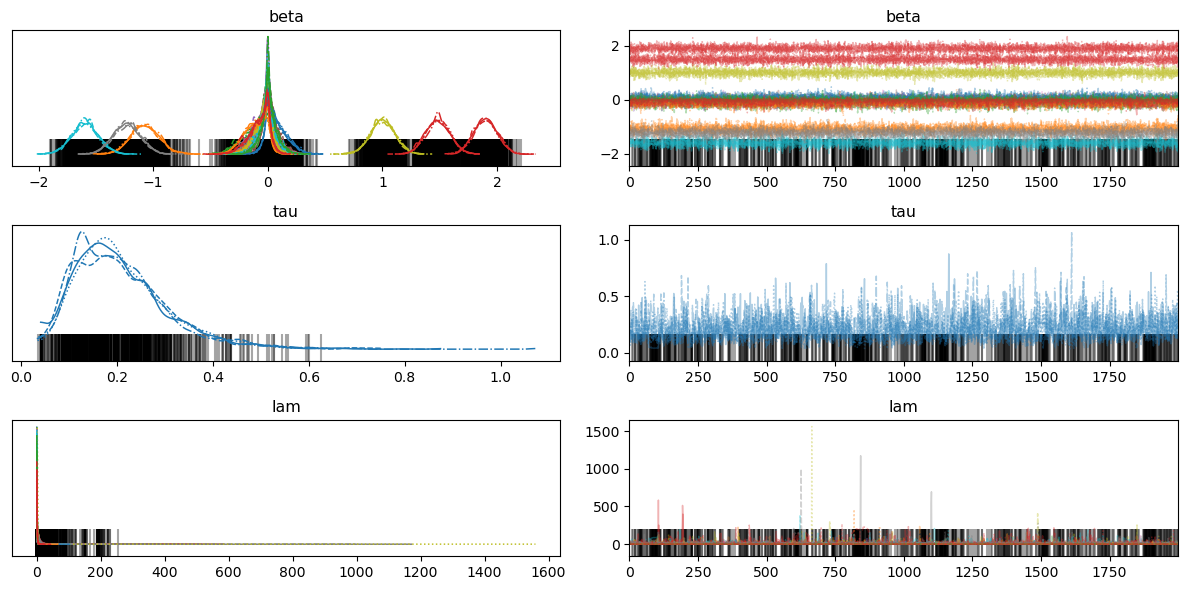

In [14]:
az.plot_trace(trace_horseshoe, var_names=['beta', 'tau', 'lam'])
plt.tight_layout()
plt.show()

The horseshoe posterior displays a strong shrinkage behavior, evident in the sharp peak around zero in the posterior of beta. This reflects the global-local shrinkage nature of the horseshoe: the global scale tau shrinks most coefficients, while the local scales lam allow a few to escape shrinkage. The presence of some wide tails indicates that certain predictors have survived the shrinkage and are likely relevant. Notably, the non-zero structure aligns with the true sparse signal simulated (B_true), suggesting good recovery of important predictors. However, the long tails in lam suggests some flexibility, which may occasionally retain some irrelevant predictors weakly. And indeed we saw some divergence in the sampling. In contrast, the spike-and-slab model(the one in Q2) exhibits more aggressive sparsity. The beta samples are heavily concentrated around zero, and many coefficients have effectively collapsed, implying the "spike" component (i.e., inactive variables). The clear binary separation in the spike variable’s histogram shows a decisive variable selection process, likely excluding irrelevant predictors entirely. This produces very crisp inclusion/exclusion decisions but may come at the cost of slightly reduced flexibility when true signals are weak or borderline.

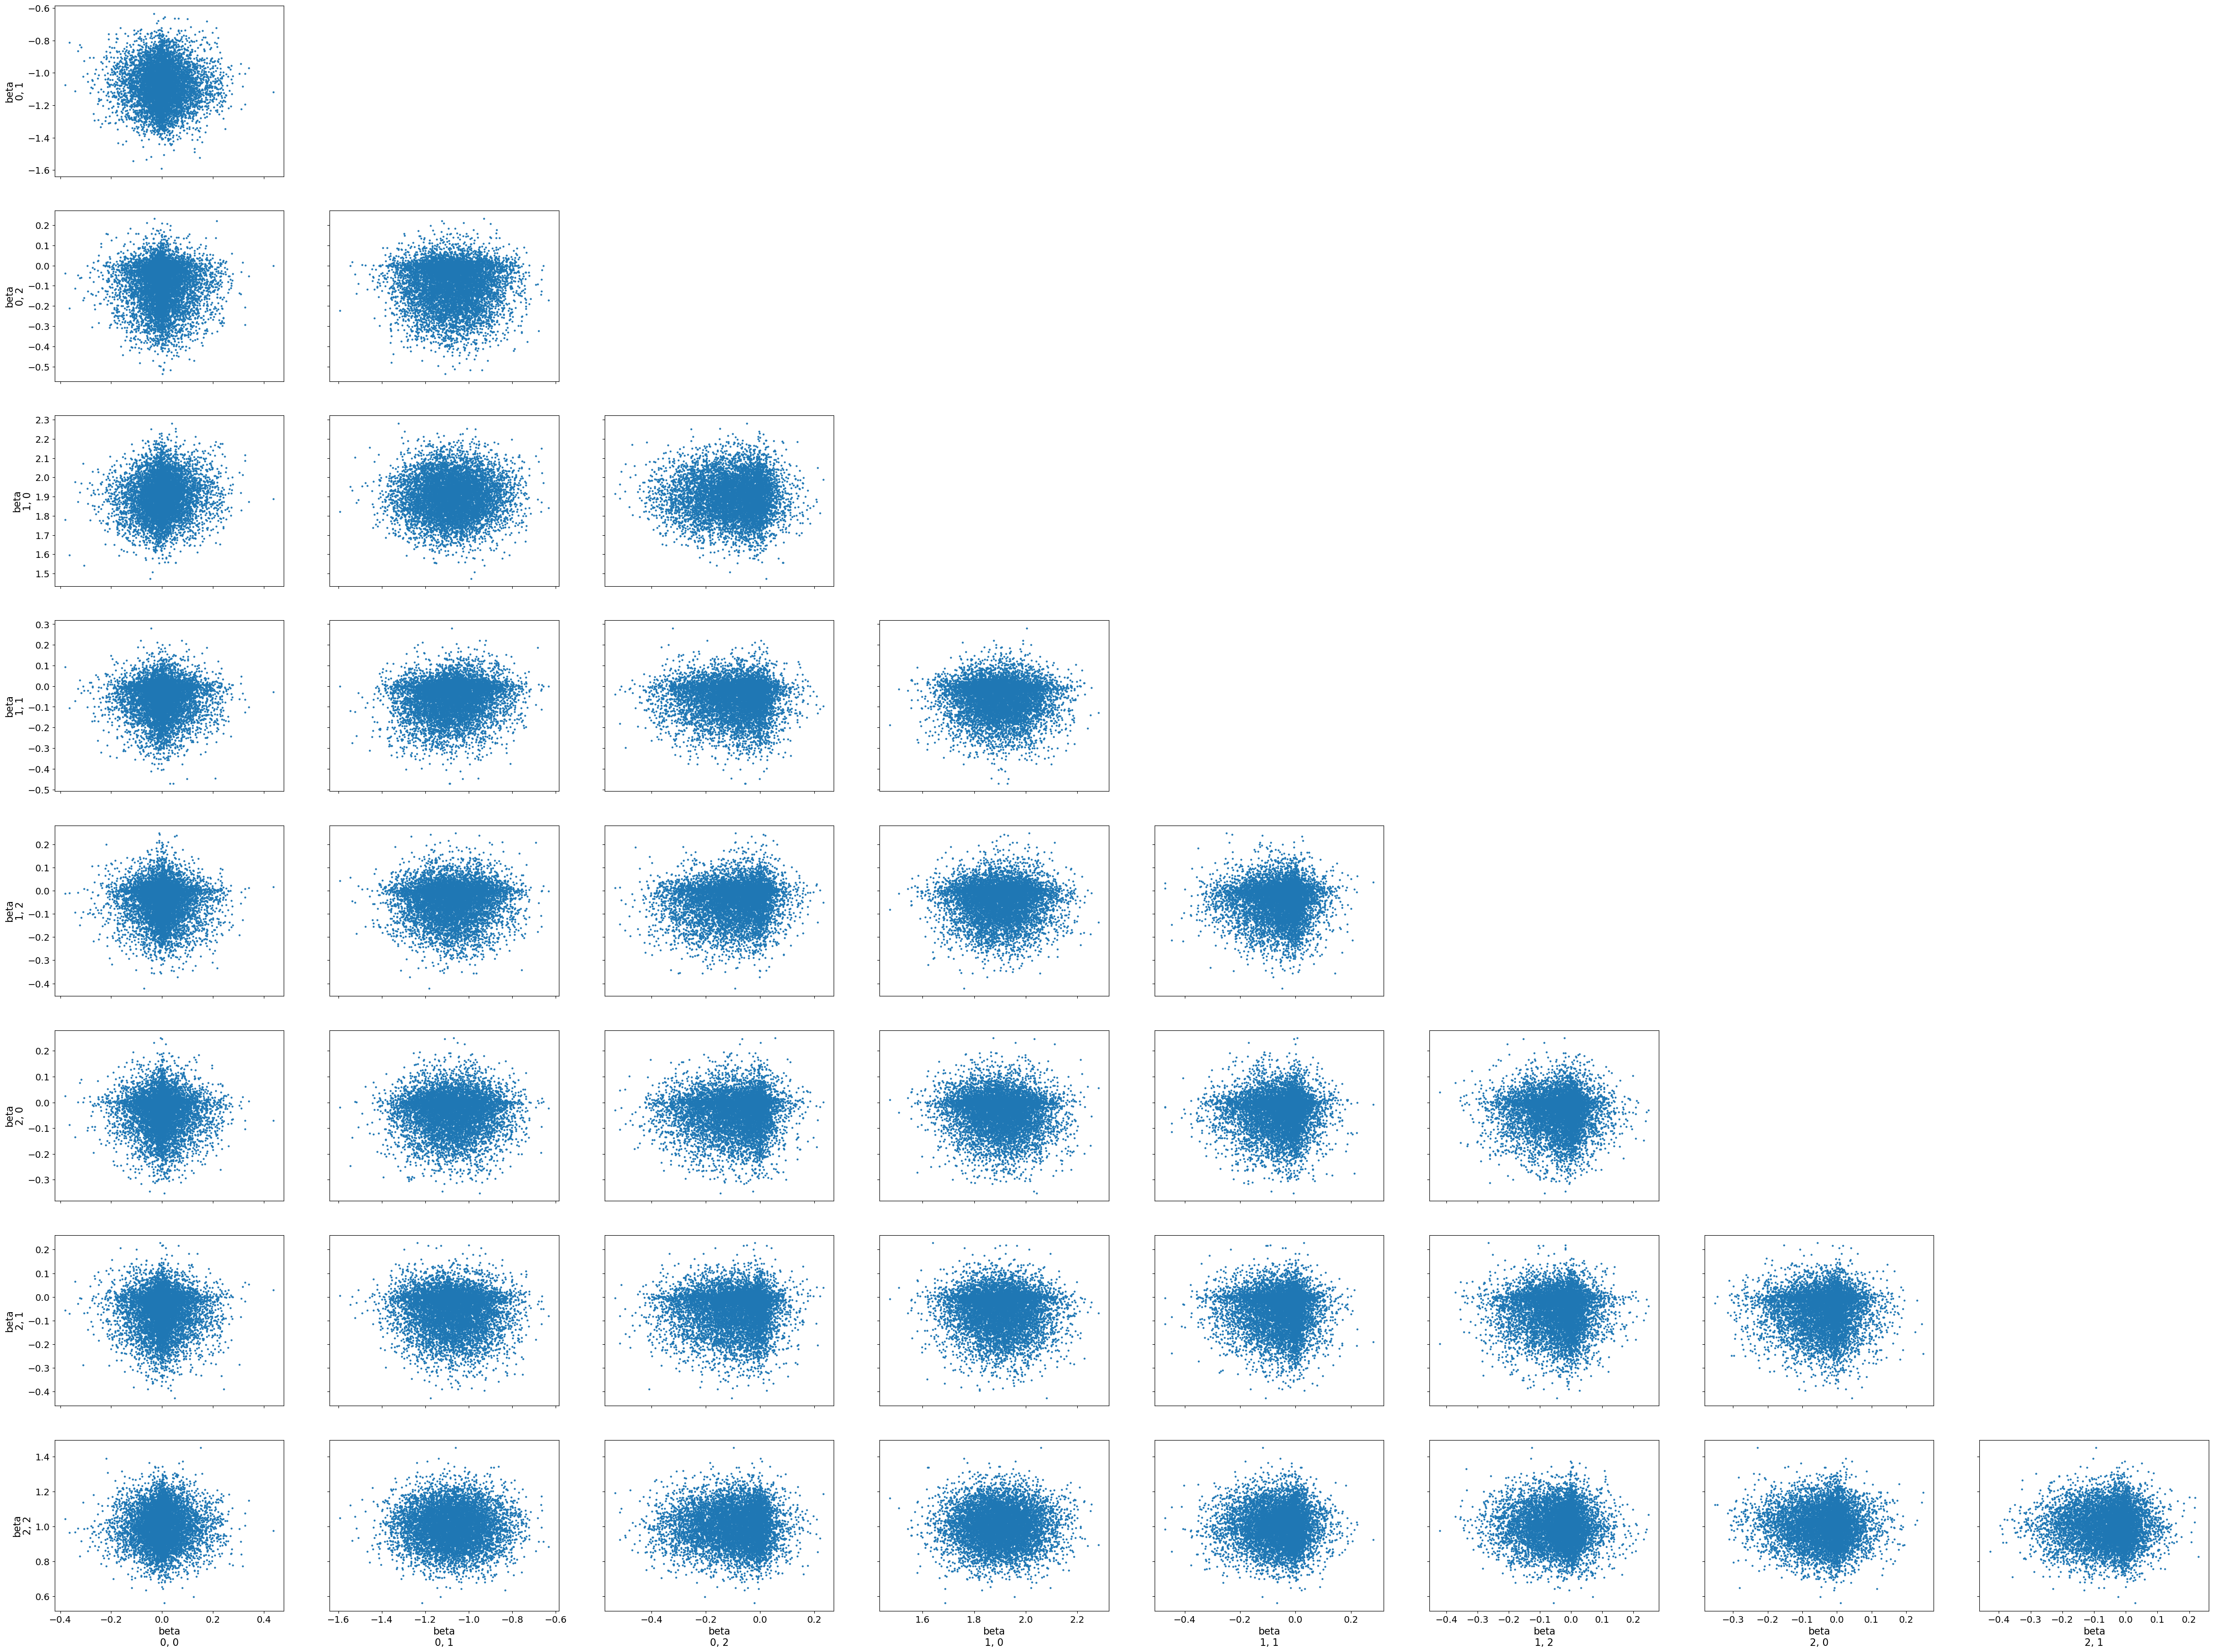

In [22]:

az.plot_pair(trace_horseshoe)
plt.show()